# Model Building - LSTM

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor


## Importing the pre-processed dataset

In [3]:
df = pd.read_excel('..\Data\gasoline_price_sentiment_pre-processed_7.xlsx', 'Sheet1')

In [4]:
df.set_index(keys='Date', drop= True, inplace= True)
df.drop('Unnamed: 0', inplace= True, axis= 1)

In [5]:
df.columns

Index(['price', 'popularity', 'general_sentiment', 'positive_outlook',
       'happiness', 'bittersweet', 'confidence', 'disgust', 'disagreement',
       'anxiety', 'gloominess', 'distress', 'violent', 'unexpectedness',
       'timeliness', 'confusion', 'feelingsVsTruth', 'buyVsSell',
       'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'volatile',
       'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log',
       'month-1', 'month-2', 'month-3', 'month-4', 'month-5'

In [11]:
selected_variable_columns = ['price', 'happiness_Log', 'bittersweet_Log',
       'disgust_Log', 'disagreement_Log', 'anxiety_Log', 'gloominess_Log',
       'distress_Log', 'violent_Log', 'unexpectedness_Log', 'confusion_Log',
       'buyVsSell_sqrt', 'pricePrediction_Log', 'volatile_Log',
       'productionCommodity_Log', 'regulatory_Log', 'supplyDemandBalance_Log',
       'exploration_Log', 'accidents_Log', 'supplyDemandBalanceForecast', 
       'consumptionCommodity', 'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth',
       'timeliness', 'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'price_rm', 'price_ewm', 'month-1', 'month-2', 
       'month-3', 'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 
       'month-9', 'month-10', 'month-11', 'month-12', 'dayofweek-0',
       'dayofweek-1', 'dayofweek-2', 'dayofweek-3', 'dayofweek-4',
       'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday']

#We are taking the transformed columns and the derived features

df_subset = df[selected_variable_columns]

## Train-test split

In [12]:
tr_start = '2010-01-08'
tr_end = '2017-03-31' 
te_start = '2017-04-01'
te_end = '2018-12-31'

In [13]:
train = df_subset[tr_start : tr_end]
test = df_subset[te_start : te_end]

## Standardization of Independent Variables

In [14]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(train.iloc[:, 1:])

y = np.reshape(np.array(train.iloc[:,0]), (-1,1))

train_scaled = np.hstack((x_scaled, y))

In [15]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(test.iloc[:, 1:])

y = np.reshape(np.array(test.iloc[:,0]), (-1,1))

test_scaled = np.hstack((x_scaled, y))

In [16]:
train_scaled.shape

(2640, 53)

In [17]:
test_scaled.shape

(640, 53)

## Preparing dataset for modelling

In [18]:
#Defining a function to split multivariate sequences into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [19]:
x_train, y_train = split_sequences(train_scaled, 7)

In [20]:
print(x_train.shape)
print(y_train.shape)

(2634, 7, 52)
(2634,)


In [21]:
x_test, y_test = split_sequences(test_scaled, 7)

In [22]:
print(x_test.shape)
print(y_test.shape)

(634, 7, 52)
(634,)


## Model-building

### Setting seed

In [23]:
#Set seed to ensure reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

#Setting seed value as 7
set_seed(7)

### Baseline Model (LSTM)

In [24]:
base_LSTM = Sequential()

base_LSTM.add(LSTM(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
#base_LSTM.add(LSTM(units = 8, activation = 'relu', return_sequences = True))
base_LSTM.add(LSTM(units = 8, activation = 'relu', return_sequences = False))
base_LSTM.add(Dense(units = 1, activation='linear'))

base_LSTM.compile(optimizer = 'adam', loss = 'mse')
base_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 16)             4416      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 5,225
Trainable params: 5,225
Non-trainable params: 0
_________________________________________________________________


In [25]:
base_LSTM.fit(x_train, y_train, epochs = 100, validation_split= 0.2, batch_size=32)

Epoch 1/100
66/66 [==============================] - 2s 9ms/step - loss: 11310.1631 - val_loss: 2944.6848
Epoch 2/100
66/66 [==============================] - 0s 4ms/step - loss: 2321.2847 - val_loss: 1014.6141
Epoch 3/100
66/66 [==============================] - 0s 4ms/step - loss: 540.5898 - val_loss: 460.0716
Epoch 4/100
66/66 [==============================] - 0s 4ms/step - loss: 311.9158 - val_loss: 305.1131
Epoch 5/100
66/66 [==============================] - 0s 4ms/step - loss: 219.0962 - val_loss: 238.2459
Epoch 6/100
66/66 [==============================] - 0s 4ms/step - loss: 166.4698 - val_loss: 195.9224
Epoch 7/100
66/66 [==============================] - 0s 4ms/step - loss: 133.0393 - val_loss: 166.6216
Epoch 8/100
66/66 [==============================] - 0s 4ms/step - loss: 108.9095 - val_loss: 146.0906
Epoch 9/100
66/66 [==============================] - 0s 5ms/step - loss: 90.7247 - val_loss: 134.6410
Epoch 10/100
66/66 [==============================] - 0s 4ms/step - l

In [26]:
pred_lstm = base_LSTM.predict(x_train)
print('The MSE for the baseline LSTM model is: {0:.2f}'.format(mean_squared_error(y_train, pred_lstm)))
print('The RMSE for the baseline LSTM model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_lstm))))
print('The MAPE for the baseline LSTM model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_lstm)))

83/83 [==============================] - 0s 1ms/step
The MSE for the baseline LSTM model is: 9.00
The RMSE for the baseline LSTM model is: 3.00
The MAPE for the baseline LSTM model is 0.02


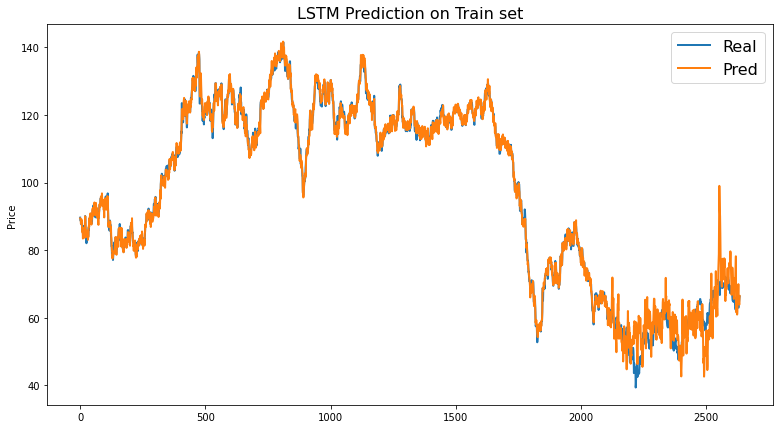

In [27]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('LSTM Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [28]:
pred_lstm = base_LSTM.predict(x_test)
print('The MSE for the baseline LSTM model is: {0:.2f}'.format(mean_squared_error(y_test, pred_lstm)))
print('The RMSE for the baseline LSTM model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_lstm))))
print('The MAPE for the baseline LSTM model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_lstm)))

20/20 [==============================] - 0s 1ms/step
The MSE for the baseline LSTM model is: 841.37
The RMSE for the baseline LSTM model is: 29.01
The MAPE for the baseline LSTM model is 0.30


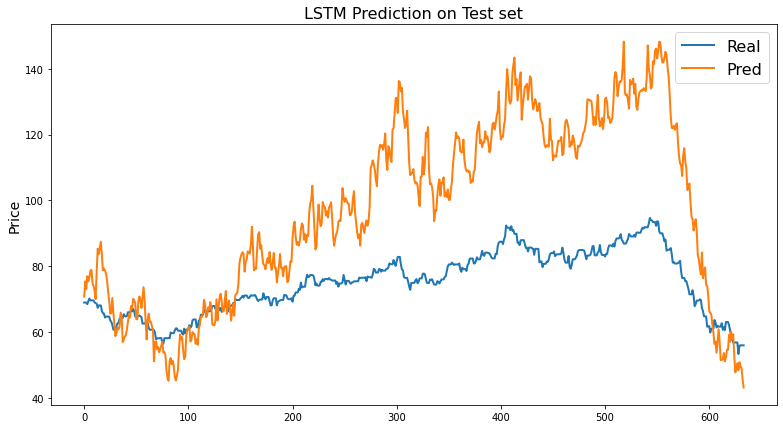

In [29]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('LSTM Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Hyperparameter Tuning (Grid Search)

#### Epochs and Batch Size

In [102]:
def create_LSTM(optimizer = 'adam'):
    model = Sequential()

    model.add(LSTM(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
    #model.add(LSTM(units = 4, activation = 'relu', return_sequences = True))
    model.add(LSTM(units = 8, activation = 'relu', return_sequences = False))
    model.add(Dense(units = 1, activation='linear'))

    model.compile(optimizer = optimizer, loss = 'mse')

    return(model)

In [104]:
base_LSTM = KerasRegressor(build_fn=create_LSTM, verbose=1)

#Defining the grid search parameters
batch_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#epochs = [10, 30, 50, 70, 90]

#Grid search
param_grid = dict(batch_size=batch_size, optimizer = optimizer)
grid = GridSearchCV(estimator=base_LSTM, param_grid=param_grid, n_jobs=-1, cv=5)
epoch_batch_size_result = grid.fit(x_train, y_train)

c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan   -549.47211914  -9829.5659668  -10174.61640625
   -636.18971558  -5177.66575928   -601.68531494             nan
  -2119.49882812  -9976.06176758 -10160.24453125  -1976.365625
  -8159.87006836  -1279.32449951             nan  -3723.80412598
 -10111.80961914 -10193.56826172  -6621.09101563  -9711.61835937
  -2419.52009277             nan  -5323.09057617 -10111.88681641
 -10179.10351562  -6027.43764648  -9750.12348633  -5558.40197754
             nan  -6921.54414063 -10075.8515625  -10158.1178

264/264 [==============================] - 3s 6ms/step - loss: 2636.4443


In [105]:
#Define a function to generate grid search results
def generate_grid_search_results(grid_result):
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [106]:
#Displaying grid search results (epochs and batch size)
generate_grid_search_results(epoch_batch_size_result)

Best: -549.472119 using {'batch_size': 10, 'optimizer': 'RMSprop'}
nan (nan) with: {'batch_size': 10, 'optimizer': 'SGD'}
-549.472119 (154.274066) with: {'batch_size': 10, 'optimizer': 'RMSprop'}
-9829.565967 (4258.705666) with: {'batch_size': 10, 'optimizer': 'Adagrad'}
-10174.616406 (4261.330804) with: {'batch_size': 10, 'optimizer': 'Adadelta'}
-636.189716 (264.190448) with: {'batch_size': 10, 'optimizer': 'Adam'}
-5177.665759 (3276.528013) with: {'batch_size': 10, 'optimizer': 'Adamax'}
-601.685315 (132.698258) with: {'batch_size': 10, 'optimizer': 'Nadam'}
nan (nan) with: {'batch_size': 20, 'optimizer': 'SGD'}
-2119.498828 (675.135624) with: {'batch_size': 20, 'optimizer': 'RMSprop'}
-9976.061768 (4199.310076) with: {'batch_size': 20, 'optimizer': 'Adagrad'}
-10160.244531 (4248.454893) with: {'batch_size': 20, 'optimizer': 'Adadelta'}
-1976.365625 (1248.887467) with: {'batch_size': 20, 'optimizer': 'Adam'}
-8159.870068 (3650.132604) with: {'batch_size': 20, 'optimizer': 'Adamax'}


#### Optimizer

In [108]:
base_LSTM = KerasRegressor(build_fn=create_LSTM, verbose=0)

#Define the grid search parameters
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [10, 30, 50, 70, 90]

param_grid = dict(optimizer= ['RMSProp'], batch_size = [10], epochs = epochs)

#Grid search
grid = GridSearchCV(estimator=base_LSTM, param_grid=param_grid, n_jobs=-1, cv=5)
optimizer_result = grid.fit(x_train, y_train)

c:\Project Directories\DSA-9 Group 7\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [109]:
generate_grid_search_results(optimizer_result)

Best: -27.776440 using {'batch_size': 10, 'epochs': 90, 'optimizer': 'RMSProp'}
-56.156718 (14.958850) with: {'batch_size': 10, 'epochs': 10, 'optimizer': 'RMSProp'}
-35.210963 (9.730049) with: {'batch_size': 10, 'epochs': 30, 'optimizer': 'RMSProp'}
-36.164603 (18.548236) with: {'batch_size': 10, 'epochs': 50, 'optimizer': 'RMSProp'}
-31.857721 (4.352726) with: {'batch_size': 10, 'epochs': 70, 'optimizer': 'RMSProp'}
-27.776440 (2.574449) with: {'batch_size': 10, 'epochs': 90, 'optimizer': 'RMSProp'}


### Optimized Model (LSTM)



In [30]:
opt_LSTM = Sequential()

opt_LSTM.add(LSTM(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
#opt_LSTM.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
opt_LSTM.add(LSTM(units = 8, activation = 'relu', return_sequences = False))
opt_LSTM.add(Dense(units = 1, activation='linear'))

opt_LSTM.compile(optimizer = 'RMSProp', loss = 'mse')
opt_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 16)             4416      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,225
Trainable params: 5,225
Non-trainable params: 0
_________________________________________________________________


In [31]:
opt_LSTM.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10)

Epoch 1/90
211/211 [==============================] - 2s 5ms/step - loss: 4185.9746 - val_loss: 473.0427
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 227.9597 - val_loss: 208.8644
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 87.2182 - val_loss: 151.0581
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 53.3292 - val_loss: 84.0023
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 36.6115 - val_loss: 86.2248
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 26.9939 - val_loss: 58.3057
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 22.3385 - val_loss: 67.6106
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 19.2840 - val_loss: 44.6332
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 17.5528 - val_loss: 41.5398
Epoch 10/90
211/211 [==============================] - 1s 4ms/step - loss: 1

In [32]:
pred_lstm = opt_LSTM.predict(x_train)
print('The MSE for the optimised LSTM model is: {0:.2f}'.format(mean_squared_error(y_train, pred_lstm)))
print('The RMSE for the optimised LSTM model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_lstm))))
print('The MAPE for the optimised LSTM model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_lstm)))

83/83 [==============================] - 0s 1ms/step
The MSE for the optimised LSTM model is: 11.67
The RMSE for the optimised LSTM model is: 3.42
The MAPE for the optimised LSTM model is 0.03


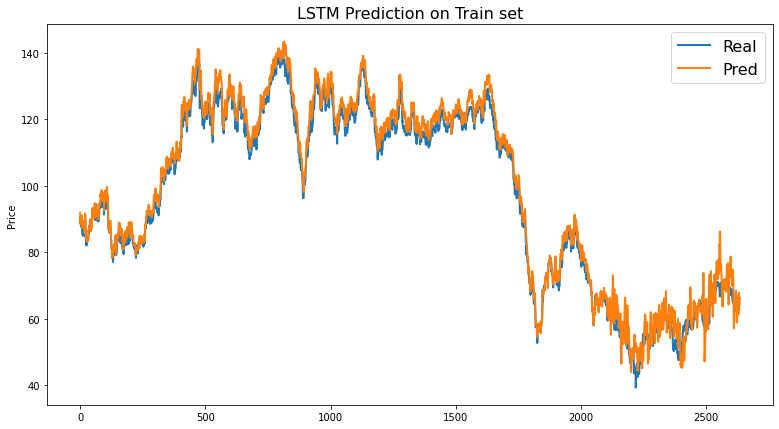

In [33]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('LSTM Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [35]:
pred_lstm = opt_LSTM.predict(x_test)
print('The MSE for the optimised LSTM model is: {0:.2f}'.format(mean_squared_error(y_test, pred_lstm)))
print('The RMSE for the optimised LSTM model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_lstm))))
print('The MAPE for the optimised LSTM model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_lstm)))

20/20 [==============================] - 0s 2ms/step
The MSE for the optimised LSTM model is: 923.34
The RMSE for the optimised LSTM model is: 30.39
The MAPE for the optimised LSTM model is 0.32


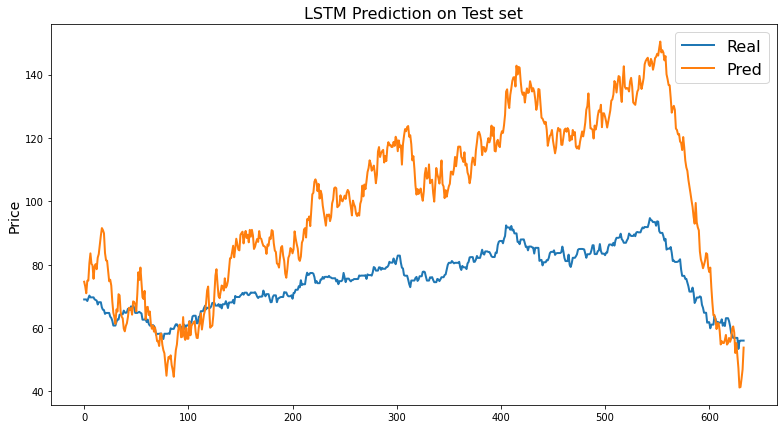

In [36]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('LSTM Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Baseline Model (LSTM) with Early Stopping

In [37]:
opt_LSTM_es = Sequential()

opt_LSTM_es.add(LSTM(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
#opt_LSTM_es.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
opt_LSTM_es.add(LSTM(units = 8, activation = 'relu', return_sequences = False))
opt_LSTM_es.add(Dense(units = 1, activation='linear'))

opt_LSTM_es.compile(optimizer = 'RMSProp', loss = 'mse')
opt_LSTM_es.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 16)             4416      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,225
Trainable params: 5,225
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Defining early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1,
    verbose=2,
    mode="auto",
    restore_best_weights=True )

In [39]:
opt_LSTM_es.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/90
211/211 [==============================] - 2s 5ms/step - loss: 3020.9690 - val_loss: 444.6166
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 217.3795 - val_loss: 150.5481
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 85.0579 - val_loss: 149.9040
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 48.1845 - val_loss: 95.6667
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 32.7264 - val_loss: 80.7150
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 26.9492 - val_loss: 63.5976
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 22.2708 - val_loss: 59.7269
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 19.6932 - val_loss: 51.1931
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 18.0022 - val_loss: 71.2662
Epoch 10/90
211/211 [==============================] - 1s 4ms/step - loss: 1

In [40]:
pred_lstm = opt_LSTM_es.predict(x_train)
print('The MSE for the optimised LSTM model with early stopping is: {0:.2f}'.format(mean_squared_error(y_train, pred_lstm)))
print('The RMSE for the optimised LSTM model with early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_lstm))))
print('The MAPE for the optimised LSTM model with early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_lstm)))

83/83 [==============================] - 0s 1ms/step
The MSE for the optimised LSTM model with early stopping is: 23.22
The RMSE for the optimised LSTM model with early stopping is: 4.82
The MAPE for the optimised LSTM model with early stopping is 0.05


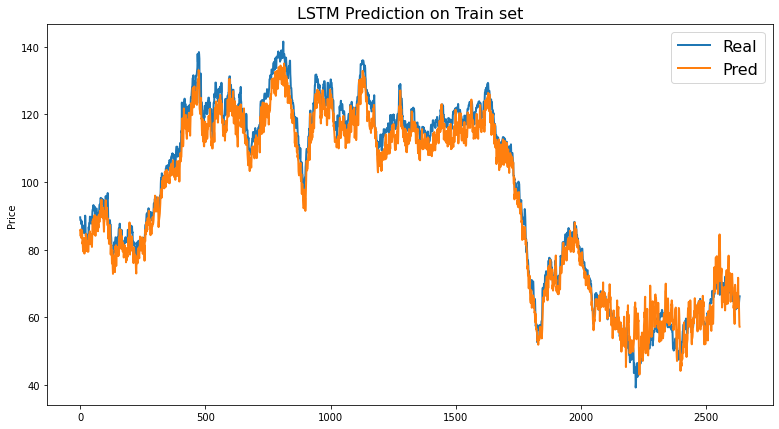

In [41]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('LSTM Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [42]:
pred_lstm = opt_LSTM_es.predict(x_test)
print('The MSE for the optimised LSTM model with early stopping is: {0:.2f}'.format(mean_squared_error(y_test, pred_lstm)))
print('The RMSE for the optimised LSTM model with early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_lstm))))
print('The MAPE for the optimised LSTM model with early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_lstm)))

20/20 [==============================] - 0s 1ms/step
The MSE for the optimised LSTM model with early stopping is: 575.41
The RMSE for the optimised LSTM model with early stopping is: 23.99
The MAPE for the optimised LSTM model with early stopping is 0.25


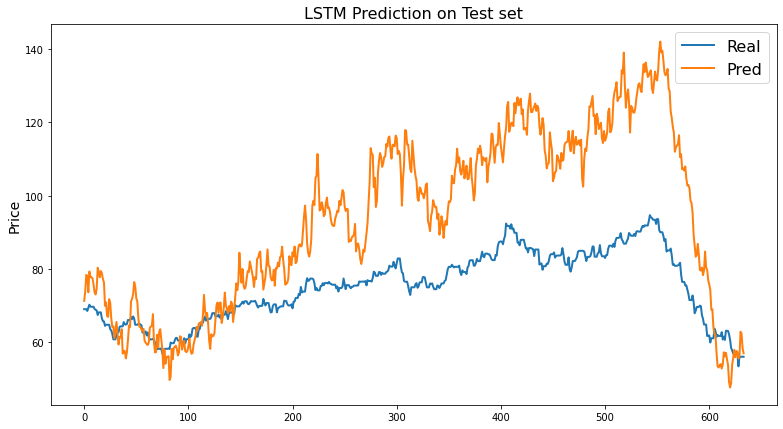

In [43]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('LSTM Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### LSTM with Dropout Layers and Early Stopping

In [44]:
dropout_LSTM = Sequential()

dropout_LSTM.add(LSTM(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
dropout_LSTM.add(Dropout(0.2))
#dropout_LSTM.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
#dropout_LSTM.add(Dropout(0.2))
dropout_LSTM.add(LSTM(units = 8, activation = 'relu', return_sequences = False))
dropout_LSTM.add(Dense(units = 1, activation='linear'))

dropout_LSTM.compile(optimizer = 'RMSProp', loss = 'mse')
dropout_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 16)             4416      
                                                                 
 dropout (Dropout)           (None, 7, 16)             0         
                                                                 
 lstm_7 (LSTM)               (None, 8)                 800       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5,225
Trainable params: 5,225
Non-trainable params: 0
_________________________________________________________________


In [45]:
dropout_LSTM.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/90
211/211 [==============================] - 3s 5ms/step - loss: 5486.7891 - val_loss: 471.6046
Epoch 2/90
211/211 [==============================] - 1s 4ms/step - loss: 308.2050 - val_loss: 132.8474
Epoch 3/90
211/211 [==============================] - 1s 4ms/step - loss: 138.5333 - val_loss: 91.6301
Epoch 4/90
211/211 [==============================] - 1s 4ms/step - loss: 86.5561 - val_loss: 66.5265
Epoch 5/90
211/211 [==============================] - 1s 4ms/step - loss: 63.7665 - val_loss: 38.7357
Epoch 6/90
211/211 [==============================] - 1s 4ms/step - loss: 55.8812 - val_loss: 42.4670
Epoch 7/90
211/211 [==============================] - 1s 4ms/step - loss: 43.3571 - val_loss: 30.1489
Epoch 8/90
211/211 [==============================] - 1s 4ms/step - loss: 37.9128 - val_loss: 25.9470
Epoch 9/90
211/211 [==============================] - 1s 4ms/step - loss: 31.3078 - val_loss: 50.2910
Epoch 10/90
211/211 [==============================] - 1s 4ms/step - loss: 2

In [50]:
pred_lstm = dropout_LSTM.predict(x_train)
print('The MSE for the LSTM model with dropout layers and early stopping is: {0:.2f}'.format(mean_squared_error(y_train, pred_lstm)))
print('The RMSE for the LSTM model with dropout layers and early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_lstm))))
print('The MAPE for the LSTM model with dropout layers and early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_lstm)))

83/83 [==============================] - 0s 2ms/step
The MSE for the LSTM model with dropout layers and early stopping is: 43.46
The RMSE for the LSTM model with dropout layers and early stopping is: 6.59
The MAPE for the LSTM model with dropout layers and early stopping is 0.06


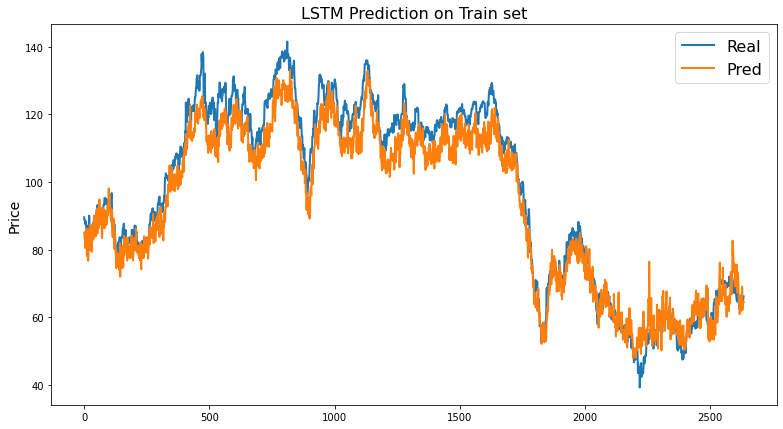

In [47]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('LSTM Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [51]:
pred_lstm = dropout_LSTM.predict(x_test)
print('The MSE for the LSTM model with dropout layers and early stopping is: {0:.2f}'.format(mean_squared_error(y_test, pred_lstm)))
print('The RMSE for the LSTM model with dropout layers and early stopping is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_lstm))))
print('The MAPE for the LSTM model with dropout layers and early stopping is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_lstm)))

20/20 [==============================] - 0s 2ms/step
The MSE for the LSTM model with dropout layers and early stopping is: 557.81
The RMSE for the LSTM model with dropout layers and early stopping is: 23.62
The MAPE for the LSTM model with dropout layers and early stopping is 0.24


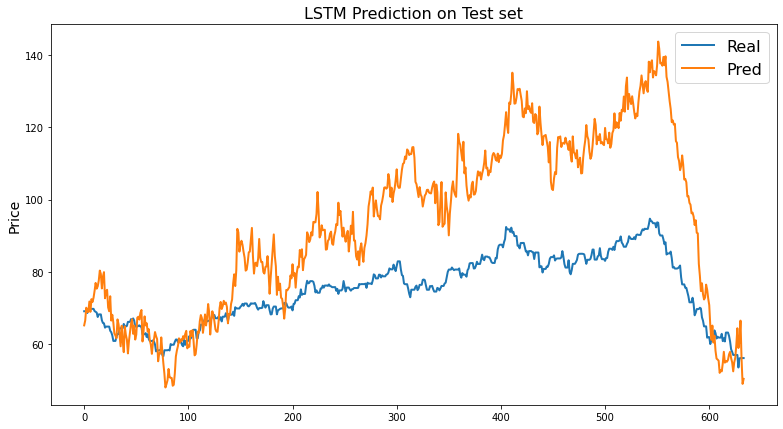

In [49]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_lstm, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('LSTM Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

## Saving models

In [52]:
base_LSTM.save('C:\Project Directories\DSA-9 Group 7\Models\LSTM\LSTM_base.h5')
opt_LSTM.save('C:\Project Directories\DSA-9 Group 7\Models\LSTM\LSTM_optimized.h5')
opt_LSTM_es.save('C:\Project Directories\DSA-9 Group 7\Models\LSTM\LSTM_optimized_es.h5')
dropout_LSTM.save('C:\Project Directories\DSA-9 Group 7\Models\LSTM\LSTM_optimized_dropout_es.h5')